In [145]:
import torch
import pandas as pd
import os, sys
import time
import cv2 as cv
from PIL import Image
import numpy as np
import random
import itertools
import datetime

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision.utils import save_image, make_grid
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torch.autograd import Variable

## 参数

In [146]:
photo_path = '../data/photo_jpg'
monet_path = '../data/monet_jpg'

BATCH_SIZE = 24
LR_RATE = 1E-3

## 查看图片

### 原图

['00068bc07f.jpg', '000910d219.jpg', '000ded5c41.jpg', '00104fd531.jpg', '001158d595.jpg', '0033c5f971.jpg', '0039ebb598.jpg', '003aab6fdd.jpg', '003c6c30e0.jpg', '00479e2a21.jpg']
../data/photo_jpg\000910d219.jpg


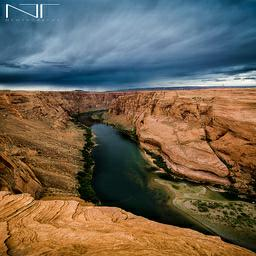

In [147]:
img_names = [name for name in list(filter(lambda x: x.endswith(".jpg"), 
                                                        os.listdir(photo_path)))]
print(img_names[:10])

img_path = os.path.join(photo_path, img_names[1])
print(img_path)

img = Image.open(img_path)
# img.show()
img

## 创建数据集

All the images for the competition are already sized to 256x256. As these images are RGB images, set the channel to 3. Additionally, we need to scale the images to a [-1, 1] scale. Because we are building a generative model, we don't need the labels or the image id so we'll only return the image from the TFRecord.


In [148]:
class ImageDataset(Dataset):
    def __init__(self, monet_path, photo_path, transform=None, unaligned=True):
        self.monet_path = monet_path
        self.photo_path = photo_path
        self.transform = transform
        self.unaligned = unaligned  # 是否对齐，即两个数据集的图片是否配对 或 图片数量是否一致
        self.monet_names = [name for name in list(filter(lambda x: x.endswith(".jpg"), 
                                                        os.listdir(self.monet_path)))]
        self.photo_names = [name for name in list(filter(lambda x: x.endswith(".jpg"), 
                                                        os.listdir(self.photo_path)))]

    def __getitem__(self, index):
        img_photo = os.path.join(self.photo_path, self.photo_names[index])
        img_photo = Image.open(img_photo).convert('RGB')

        if self.unaligned:
                    img_monet = os.path.join(self.monet_path, \
                                             self.monet_names[random.randint(0, len(self.monet_names)) - 1])
                    img_monet = Image.open(img_monet).convert('RGB')
        else:         
            img_monet = os.path.join(self.monet_path, self.monet_names[index % len(self.monet_names)])
            img_monet = Image.open(img_monet).convert('RGB')

        if self.transform is not None:
            img_monet = self.transform(img_monet)
            img_photo = self.transform(img_photo)

        return {"monet": img_monet, "photo": img_photo}

    def __len__(self):
        return max(len(self.monet_names), len(self.photo_names))

In [149]:
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     # transforms.Normalize(mean=[0.4038, 0.4086, 0.3840], std=[0.2219, 0.2027, 0.2198])
#     transforms.Lambda(lambda x: (x / 127.5) - 1)
# ])

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    # transforms.Lambda(lambda x: (x / 127.5) - 1)
    # # 无normalize：
    # # Mean: tensor([0.4038, 0.4086, 0.3840])
    # # Std: tensor([0.2219, 0.2027, 0.2198])

    # # 有normalize:
    # # Mean: tensor([-0.1924, -0.1828, -0.2319])
    # # Std: tensor([0.4438, 0.4055, 0.4396])
])

def denorm(x):
    # out = (x + 1) / 2
    out = x * 0.5 + 0.5
    return torch.clamp(out, 0, 1)

ds = ImageDataset(monet_path, photo_path, transform)
dataloader = DataLoader(ds, BATCH_SIZE, shuffle=True)
print(f'BATCH_SZIE: {BATCH_SIZE}, len(dataset): {len(ds)}, len(dataloader_photo): {len(dataloader)}')
print(f"ds[0]['monet'].shape: {ds[0]['monet'].shape}")

BATCH_SZIE: 24, len(dataset): 7038, len(dataloader_photo): 294
ds[0]['monet'].shape: torch.Size([3, 256, 256])


In [150]:
# from tqdm import tqdm
# mean = 0.
# std = 0.
# n_images = 0
# i = 0
# for batch in tqdm(dataloader):
#     # print(f'{i}/{len(dataloader)}')
#     batch_size = batch['photo'].size(0)
#     # 将 batch_size x 3 x H x W 的张量变成 (batch_size x H x W) x 3
#     batch_m = batch['photo'].view(batch_size, 3, -1)
#     # 计算每个通道上的均值和标准差
#     mean += batch_m.mean(2).sum(0)
#     std += batch_m.std(2).sum(0)
#     n_images += batch_size
#     # i += 1

# # 将均值和标准差除以样本数
# mean /= n_images
# std /= n_images

# print(f"Mean: {mean}")
# print(f"Std: {std}")

# # 无normalize：
# # Mean: tensor([0.4038, 0.4086, 0.3840])
# # Std: tensor([0.2219, 0.2027, 0.2198])

# # 有normalize:
# # Mean: tensor([-0.1924, -0.1828, -0.2319])
# # Std: tensor([0.4438, 0.4055, 0.4396])

# # for i in range(6):
# #     print(batch['photo'][i].min(dim=0))  #其实已经事先缩放到[0, 1]了，加了normalize后缩放到[-1, 1], 负数居多
# #     print('*'*50 + '\n')

## Build the generator

In [151]:
class downsample(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size=4, 
                 stride=2, padding=1, apply_instancenorm=True):
        super().__init__()
        self.net = nn.ModuleList([nn.Conv2d(in_channel, out_channel, kernel_size, stride, 
                                            padding, bias=False)])
        
        if apply_instancenorm:
            self.net.append(nn.InstanceNorm2d(out_channel))

        self.net.append(nn.LeakyReLU())

    def forward(self, x):
        for layer in self.net:
            x = layer(x)
        return x

class upsample(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size=4, stride=2, padding=1):
        super().__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(in_channel, out_channel, kernel_size, stride, padding),
            nn.InstanceNorm2d(out_channel),
            nn.ReLU() # inplace会覆盖原内存
        )

    def forward(self, x):
        return self.model(x)
    
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
        if hasattr(m, "bias") and m.bias is not None:
            torch.nn.init.constant_(m.bias.data, 0.0)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

class ReplayBuffer:
    def __init__(self, max_size=50):
        assert max_size > 0, "Empty buffer or trying to create a black hole. Be careful."
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0, 1) > 0.5:
                    i = random.randint(0, self.max_size - 1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return Variable(torch.cat(to_return))

In [152]:
class Generator(nn.Module):
    def __init__(self, in_channels=3):
        super(Generator, self).__init__()

        # Input: [bs, 3， 256, 256]
        self.down_stack = nn.ModuleList([
            downsample(in_channels, 64, apply_instancenorm=False), # [bs, 64, 128, 128]  
            downsample(64,  128),       # [bs, 128, 64, 64]
            downsample(128, 256),       # [bs, 256, 32, 32]
            downsample(256, 512),       # [bs, 512, 16, 16]
            downsample(512, 512),       # [bs, 512, 8, 8]
            downsample(512, 512),       # [bs, 512, 4, 4]
            downsample(512, 512),       # [bs, 512, 2, 2]
            downsample(512, 512, apply_instancenorm=False),       # [bs, 512, 1, 1]
        ])

        self.up_stack = nn.ModuleList([
            upsample(512, 512),  # (bs, 1024, 2, 2)  拼接后的shape
            upsample(1024, 512), # (bs, 1024, 4, 4)  拼接后 in_channels = 上一层的 out_channels * 2
            upsample(1024, 512), # (bs, 1024, 8, 8)
            upsample(1024, 512), # (bs, 1024, 16, 16)
            upsample(1024, 256), # (bs, 512, 32, 32)
            upsample(512, 128),  # (bs, 256, 64, 64)
            upsample(256, 64),   # (bs, 128, 128, 128)
        ])

        self.last = upsample(128, 3) 

    def forward(self, x):
        # Downsampling through the model
        skips = []
        for down in self.down_stack:
            x = down(x)
            skips.append(x)

        skips = reversed(skips[:-1])

        # Upsampling and establishing the skip connections
        for up, skip in zip(self.up_stack, skips):
            x = up(x)
            x = torch.cat([x, skip], dim=1)

        out = self.last(x)

        return out 

In [153]:
class Discriminator(nn.Module):
    def __init__(self, input_shape=(3, 256, 256)):
        super(Discriminator, self).__init__()  
        
        in_channels, height, width = input_shape

        # Calculate output shape of image discriminator (PatchGAN)
        self.output_shape = (1, height // 2 ** 4, width // 2 ** 4)

        self.model = nn.ModuleList(
            [   # input: [bs, 3, 256, 256]
                downsample(in_channels, 64, apply_instancenorm=False), # [bs, 64, 128, 128] , apply_instancenorm=False
                downsample(64, 128),        # [bs, 128, 64, 64]
                downsample(128, 256),       # [bs, 256, 32, 32]
                downsample(256, 512),       # [bs, 512, 16, 16]
                nn.ZeroPad2d((1, 0, 1, 0)), # [bs, 512, 17, 17]
                nn.Conv2d(512, 1, 4, padding=1) # [bs, 1, 16, 16]
            ]
    )
    
    def forward(self, x):
        for layer in self.model:
            x = layer(x)
            
        return x

## 训练模型

In [154]:
img_shape = tuple(ds[0]['photo'].shape)
print(f'img_shape: {img_shape}')

EPOCHS = 20
IN_CHANNELS = 3
b1 = 0.5    # adam: decay of first order momentum of gradient
b2 = 0.999  # adam: decay of first order momentum of gradient
img_height = 256
img_width = 256
lambda_cyc = 10.0
lambda_id = 5.0

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

# Losses
criterion_GAN = nn.MSELoss()
criterion_cycle = nn.L1Loss()
criterion_identity = nn.L1Loss()

# Initialize generator and discriminator
G_photo2monet = Generator()
G_monet2photo = Generator()
D_photo = Discriminator()
D_monet = Discriminator()

if torch.cuda.is_available():
    G_photo2monet.to(device)
    G_monet2photo.to(device)
    D_monet.to(device)
    D_photo.to(device)

if EPOCHS != 0:
    G_photo2monet.apply(weights_init_normal)
    G_monet2photo.apply(weights_init_normal)
    D_photo.apply(weights_init_normal)
    D_monet.apply(weights_init_normal)

optimizer_G = torch.optim.Adam(
    itertools.chain(G_photo2monet.parameters(), G_monet2photo.parameters()), lr=LR_RATE, betas=(b1, b2)
)
optimizer_D_monet = torch.optim.Adam(D_monet.parameters(), lr=LR_RATE, betas=(b1, b2))
optimizer_D_photo = torch.optim.Adam(D_photo.parameters(), lr=LR_RATE, betas=(b1, b2))

# Buffers of previously generated samples
fake_photo_buffer = ReplayBuffer()
fake_monet_buffer = ReplayBuffer()

Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.Tensor

img_shape: (3, 256, 256)
Device: cuda:1


In [155]:
def sample_images(batches_done, save_path):
    """Saves a generated sample from the test set"""
    imgs = next(iter(dataloader))
    G_photo2monet.eval()
    G_monet2photo.eval()
    real_A = Variable(imgs["photo"].type(Tensor)).to(device)
    fake_B = G_photo2monet(real_A)
    real_B = Variable(imgs["monet"].type(Tensor)).to(device)
    fake_A = G_monet2photo(real_B)
    # Arange images along x-axis
    real_A = make_grid(real_A, nrow=5, normalize=True)
    real_B = make_grid(real_B, nrow=5, normalize=True)
    fake_A = make_grid(denorm(fake_A), nrow=5, normalize=True)
    fake_B = make_grid(denorm(fake_B), nrow=5, normalize=True)
    # Arange images along y-axis
    image_grid = torch.cat((real_A, fake_B, real_B, fake_A), 1)
    save_image(image_grid, f"{save_path}/pictures/{batches_done}.png", normalize=False)

In [156]:
save_time = time.strftime("%Y%m%d_%H%M%S", time.localtime())
save_path = f'result/runs_{save_time}/'
print(f'Local time: {save_time}')
os.makedirs(f'result/runs_{save_time}/pictures')  
os.makedirs(f'result/runs_{save_time}/saved_models')

prev_time = time.time()
for epoch in range(EPOCHS):
    for i, batch in enumerate(dataloader):
        
        # Set model input
        real_photo = batch['photo'].to(device)
        real_monet = batch['monet'].to(device)
        
        # Adversarial ground truths
        valid = torch.ones((real_photo.size(0), *D_photo.output_shape)).to(device)
        fake = torch.zeros((real_photo.size(0), *D_photo.output_shape)).to(device)

        # ------------------
        #  Train Generators
        # ------------------
        
        G_photo2monet.train()
        G_monet2photo.train()

        optimizer_G.zero_grad()

        # Identity loss
        loss_id_photo = criterion_identity(G_monet2photo(real_photo), real_photo)
        loss_id_monet = criterion_identity(G_photo2monet(real_monet), real_monet)
        loss_identity = (loss_id_photo + loss_id_monet) / 2

        # GAN loss
        fake_monet = G_photo2monet(real_photo)
        fake_photo = G_monet2photo(real_monet)
        valid_G = torch.zeros_like(fake_monet).to(device)
        loss_gan_photo2monet = criterion_GAN(fake_monet, valid_G)
        loss_gan_monet2photo = criterion_GAN(fake_photo, valid_G)
        loss_gan = (loss_gan_monet2photo + loss_gan_photo2monet) / 2
        
        # Cycle loss
        recov_photo = G_monet2photo(fake_monet)
        recov_monet = G_photo2monet(fake_photo)
        loss_cycle_photo = criterion_cycle(recov_photo, real_photo)
        loss_cycle_monet = criterion_cycle(recov_monet, real_monet)
        loss_cycle = (loss_cycle_monet + loss_cycle_photo) / 2

        # Total loss
        loss_G = loss_gan + lambda_cyc * loss_cycle + lambda_id * loss_identity
        loss_G.backward()
        optimizer_G.step()

        # -----------------------
        #  Train Discriminator photo
        # -----------------------
        optimizer_D_photo.zero_grad()

        # Real loss
        loss_real = criterion_GAN(D_photo(real_photo), valid)
        # Fake loss (on batch of previously generated samples)
        fake_photo_ = fake_photo_buffer.push_and_pop(fake_photo)
        loss_fake = criterion_GAN(D_photo(fake_photo_.detach()), fake)
        # Total loss
        loss_D_photo = (loss_real + loss_fake) / 2
        loss_D_photo.backward()
        optimizer_D_photo.step()

        # -----------------------
        #  Train Discriminator monet
        # -----------------------
        optimizer_D_monet.zero_grad()

        # Real loss
        loss_real = criterion_GAN(D_monet(real_monet), valid)
        # Fake loss (on batch of previously generated samples)
        fake_monet_ = fake_monet_buffer.push_and_pop(fake_monet)
        loss_fake = criterion_GAN(D_monet(fake_monet_.detach()), fake)
        # Total loss
        loss_D_monet = (loss_real + loss_fake) / 2
        loss_D_monet.backward()
        optimizer_D_monet.step()

        loss_D = (loss_D_monet + loss_D_photo) / 2

        # --------------
        #  Log Progress
        # --------------

        # Determine approximate time left
        batches_done = epoch * len(dataloader) + i
        batches_left = EPOCHS * len(dataloader) - batches_done
        time_left = datetime.timedelta(seconds=batches_left * (time.time() - prev_time))
        prev_time = time.time()

        # Print log
        print(
            "\r[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f, adv: %f, cycle: %f, identity: %f] ETA: %s"
            % (
                epoch,
                EPOCHS,
                i,
                len(dataloader),
                loss_D.item(),
                loss_G.item(),
                loss_gan.item(),
                loss_cycle.item(),
                loss_identity.item(),
                time_left,
            )
        )

        # If at sample interval save image
        if batches_done % 100 == 0:
            sample_images(batches_done, save_path)

        # if batches_done % 100 == 0:
        #     save_image(fake_monet.data[:25], f"result/runs_{save_time}/pictures/fake_monet_{batches_done}.png", nrow=5, normalize=True)
        #     save_image(fake_photo.data[:25], f"result/runs_{save_time}/pictures/fake_photo_{batches_done}.png", nrow=5, normalize=True)

# Save model checkpoints
torch.save(G_photo2monet.state_dict(), f"result/runs_{save_time}/saved_models/G_photo2monet.pth")
torch.save(G_monet2photo.state_dict(), f"result/runs_{save_time}/saved_models/G_monet2photo.pth")
torch.save(D_photo.state_dict(), f"result/runs_{save_time}/saved_models/D_photo.pth")
torch.save(D_monet.state_dict(), f"result/runs_{save_time}/saved_models/D_monet.pth")

Local time: 20230416_222502
[Epoch 0/20] [Batch 0/294] [D loss: 2.095480] [G loss: 11.007124, adv: 0.489736, cycle: 0.701216, identity: 0.701046] ETA: 0:29:16.001873
[Epoch 0/20] [Batch 1/294] [D loss: 51.537117] [G loss: 8.582031, adv: 0.386918, cycle: 0.530616, identity: 0.577791] ETA: 8:03:24.733618
[Epoch 0/20] [Batch 2/294] [D loss: 36.180504] [G loss: 6.980224, adv: 0.221411, cycle: 0.448313, identity: 0.455137] ETA: 2:53:34.784989
[Epoch 0/20] [Batch 3/294] [D loss: 13.367756] [G loss: 6.814160, adv: 0.108394, cycle: 0.445937, identity: 0.449279] ETA: 2:56:07.311765
[Epoch 0/20] [Batch 4/294] [D loss: 2.336276] [G loss: 6.845459, adv: 0.116914, cycle: 0.450095, identity: 0.445520] ETA: 2:54:51.435781
[Epoch 0/20] [Batch 5/294] [D loss: 1.285572] [G loss: 6.471760, adv: 0.073179, cycle: 0.427361, identity: 0.424995] ETA: 2:53:38.392032
[Epoch 0/20] [Batch 6/294] [D loss: 0.620542] [G loss: 6.543404, adv: 0.095667, cycle: 0.430919, identity: 0.427710] ETA: 2:55:06.160586
[Epoch 0/

In [ ]:
print(real_photo.shape)
print(real_photo.max(dim=1))
print(real_photo.min(dim=1))
# imgs = next(iter(dataloader))
# img = imgs['photo'][0]

# img = real_photo[2].cpu()
# plt.imshow(img.permute(1,2,0))

# G_photo2monet.eval()
# G_monet2photo.eval()
# real_A = Variable(imgs["photo"].type(Tensor)).to(device)
# fake_B = G_photo2monet(real_A)
# fake_B.shape

torch.Size([24, 3, 256, 256])
torch.return_types.max(
values=tensor([[[ 0.1373,  0.1451,  0.1451,  ..., -0.0824, -0.0824, -0.0824],
         [ 0.1373,  0.1373,  0.1451,  ..., -0.0824, -0.0824, -0.0824],
         [ 0.1373,  0.1373,  0.1451,  ..., -0.0980, -0.0980, -0.0980],
         ...,
         [ 0.2000, -0.0118, -0.0510,  ..., -0.7020, -0.7725, -0.5922],
         [-0.0588, -0.0196,  0.2000,  ..., -0.7412, -0.8275, -0.6784],
         [-0.1686, -0.0510, -0.0118,  ..., -0.6471, -0.7725, -0.7098]],

        [[ 0.5686,  0.5686,  0.5529,  ...,  0.7333,  0.7569,  0.7804],
         [ 0.5451,  0.5451,  0.5294,  ...,  0.7098,  0.7333,  0.7490],
         [ 0.5137,  0.5137,  0.5216,  ...,  0.6863,  0.6941,  0.7098],
         ...,
         [-0.4824, -0.5451, -0.5059,  ..., -0.4196, -0.4039, -0.3882],
         [-0.4824, -0.6157, -0.5451,  ..., -0.4588, -0.4510, -0.4275],
         [-0.4510, -0.6314, -0.5686,  ..., -0.4118, -0.4118, -0.3961]],

        [[-0.3725, -0.3725, -0.3647,  ..., -0.4745, -0.

0 torch.Size([3, 256, 256])
1 torch.Size([3, 256, 256])
2 torch.Size([3, 256, 256])
3 torch.Size([3, 256, 256])
4 torch.Size([3, 256, 256])
5 torch.Size([3, 256, 256])


IndexError: index 5 is out of bounds for axis 0 with size 5

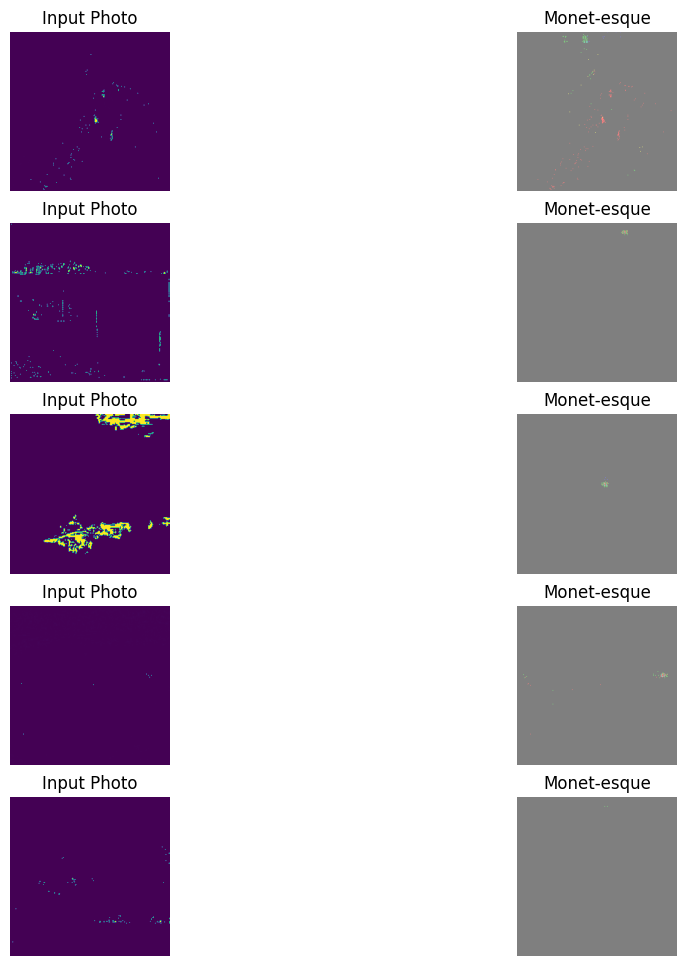

In [ ]:
import matplotlib.pyplot as plt

_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(real_A):
    print(i, img.shape)
    fake_monet = fake_B.cpu().detach().numpy().astype(np.uint8)
    fake_monet = (fake_monet * 127.5 + 127.5).astype(np.uint8)
    img = img.cpu().detach().numpy().astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(fake_monet[i].transpose(1,2,0))
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()